In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

df = pd.read_csv('apartments_pl_2006-2017.csv')
df

,Quarter,City,Price type,Price
0,2007-1,Bialystok,offer price,4181.000000
1,2007-1,Bialystok,transaction price,3500.000000
2,2007-1,Bydgoszcz,offer price,4501.000000
3,2007-1,Bydgoszcz,transaction price,3017.000000
4,2007-1,Gdansk,offer price,6437.000000
...,...,...,...,...
1537,2017-4,Warsaw,transaction price,7750.880271
1538,2017-4,Wroclaw,offer price,6526.141896
1539,2017-4,Wroclaw,transaction price,6389.000000
1540,2017-4,Zielona Gora,offer price,3937.000000


In [2]:
df['Quarter'] = pd.to_datetime(df['Quarter'])

def change_month(date):
    if date.month == 2:
        return date.replace(month=4)
    elif date.month == 3:
        return date.replace(month=7)
    elif date.month == 4:
        return date.replace(month=10)
    else:
        return date

df['Quarter'] = df['Quarter'].apply(change_month)

df = df.set_index('Quarter')
df

,City,Price type,Price
Quarter,,,
2007-01-01,Bialystok,offer price,4181.000000
2007-01-01,Bialystok,transaction price,3500.000000
2007-01-01,Bydgoszcz,offer price,4501.000000
2007-01-01,Bydgoszcz,transaction price,3017.000000
2007-01-01,Gdansk,offer price,6437.000000
...,...,...,...
2017-10-01,Warsaw,transaction price,7750.880271
2017-10-01,Wroclaw,offer price,6526.141896
2017-10-01,Wroclaw,transaction price,6389.000000


In [3]:
# spr., ile jest nulli
df.isnull().sum()

City          0
Price type    0
Price         4
dtype: int64

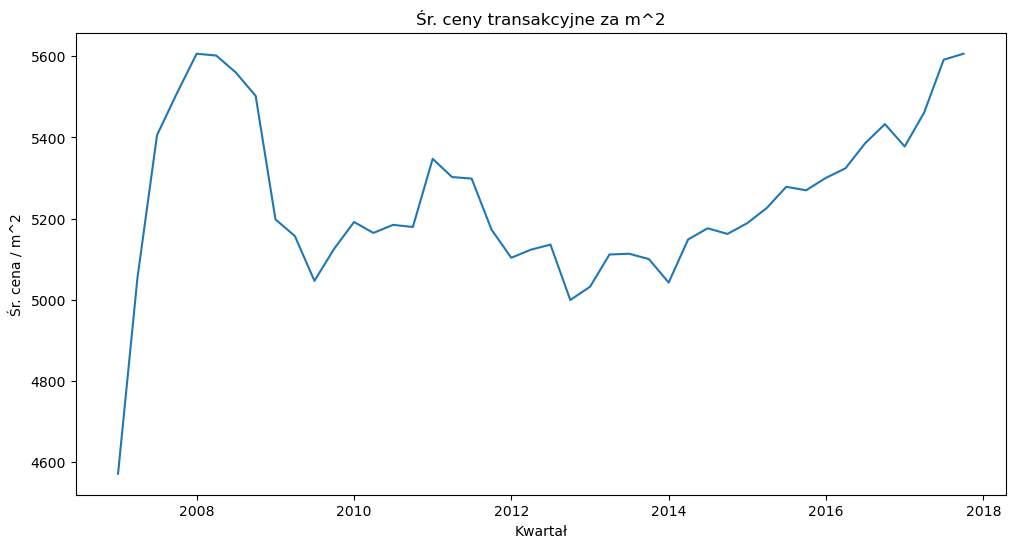

In [4]:
# nie ma dużo nulli, usuwamy wszystkie
df = df.dropna()

# zawężenie do danych transakcyjnych
df_trans = df[df['Price type'] == 'transaction price']
df_trans = df_trans.sort_values(by=['Quarter'])

# wyliczenie średnich cen dla każdego kwartału
df_avg_trans = df_trans.groupby('Quarter')['Price'].mean().reset_index()

# brakuje danych dla 2006-4, więc usuwamy rekordy z 2006 r.
df_avg_trans = df_avg_trans[~(df_avg_trans['Quarter'].dt.year == 2006)].reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.title('Śr. ceny transakcyjne za m^2')
plt.plot(df_avg_trans['Quarter'], df_avg_trans['Price'])
plt.xlabel('Kwartał')
plt.ylabel('Śr. cena / m^2')
plt.show()

In [5]:
# test, czy szereg czasowy jest stacjonarny
result = adfuller(df_avg_trans['Price'], autolag='AIC')
print(f'Statystyka ADF: {result[0]}')
print(f'Wartość p: {result[1]}')

Statystyka ADF: -3.4385708827896106
Wartość p: 0.009712197636596507


In [6]:
# spr. wartości krytyczne
for key, value in result[4].items():
    print(f'   {key}: {value}')

   1%: -3.5925042342183704
   5%: -2.931549768951162
   10%: -2.60406594375338


In [7]:
# p < 0.05 i ADF < wartości krytycznej dla 5%, więc istnieją przesłanki za tym, że szereg czasowy jest stacjonarny dla p=0.05.
# Wynika z tego m. in. brak trendów / sezonowości.

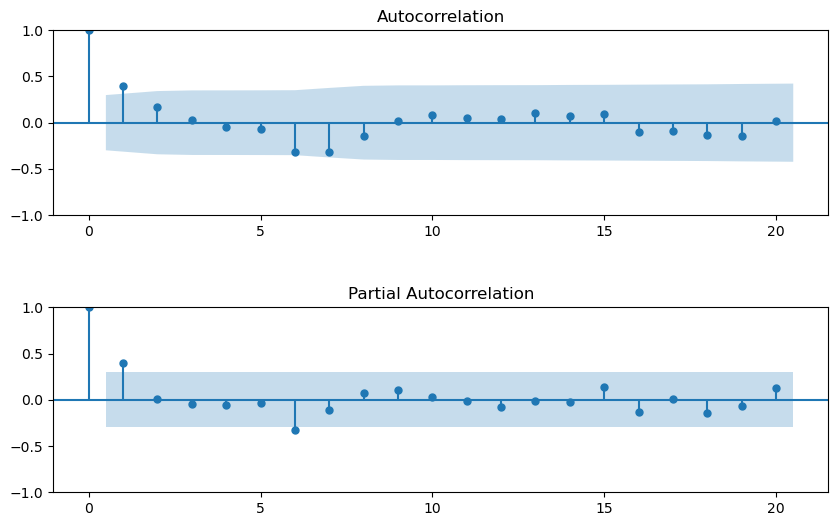

In [8]:
# Zastosowany będzie model ARIMA (AutoRegressive Integrated Moving Average)

# poniżej - różnicowanie; gdyby szereg nie był stacjonarny
diff_series = df_avg_trans['Price'].diff().dropna() 

# wybór parametrów modelu ARIMA - na podstawie ACF i PACF
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
plt.subplots_adjust(hspace=0.5)

plot_acf(diff_series, lags=20, ax=ax[0])
plot_pacf(diff_series, lags=20, ax=ax[1], method='ywm')

plt.show()

In [9]:
# dodanie częstotliwości kwartalnej do indeksu
df_avg_trans.index = pd.to_datetime(df_avg_trans.index)
df_avg_trans.index = pd.date_range(start=df_avg_trans.index[0], periods=len(df_avg_trans), freq='Q')

# sortowanie chronologicznie
df_avg_trans = df_avg_trans.sort_index()

# trenowanie modelu
model = ARIMA(df_avg_trans['Price'], order=(2, 0, 2))
results = model.fit()

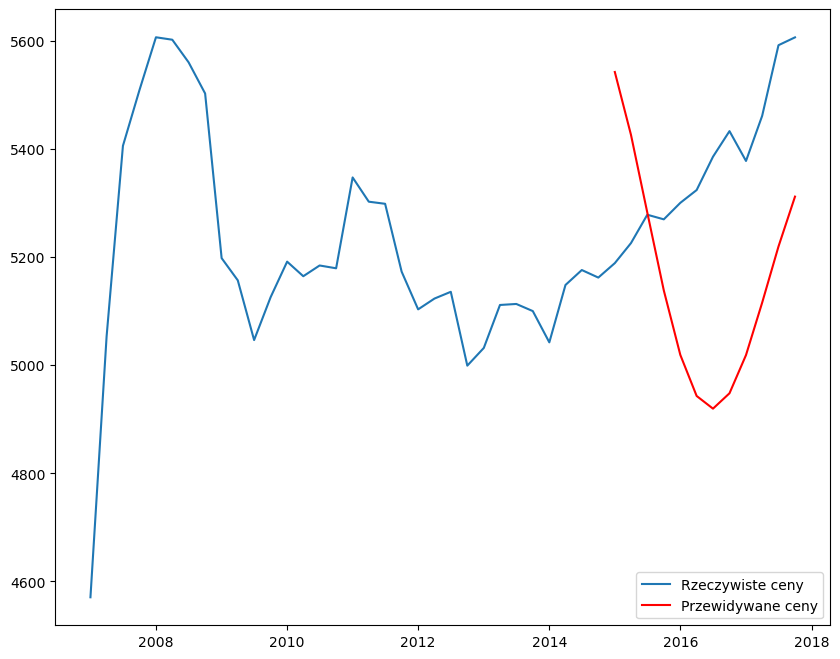

In [10]:
# przygotowanie zbioru testowego (przyjmujemy ostatnie n kwartałów)
test_set = df_avg_trans['Price'].tail(n=12)

# prognoza na zbiorze testowym
predictions = results.get_forecast(steps=len(test_set))

quarters = df_avg_trans['Quarter']
plt.figure(figsize=(10, 8))
plt.plot(quarters, df_avg_trans['Price'], label='Rzeczywiste ceny')
plt.plot(quarters[-len(test_set):], predictions.predicted_mean,
         label='Przewidywane ceny', color='red')
plt.legend()
plt.show()

In [11]:
# przewidywane wartości na pełnym zbiorze danych
predicted_values = results.fittedvalues

# obl. błędu średniokwadratowego na zbiorze testowym
mse = mean_squared_error(df_avg_trans['Price'], predicted_values)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 20171.44025788286


In [12]:
# Czyli model myli się w oszacowywaniu średniej ceny ofertowej za metr średnio o ok. 142 zł.

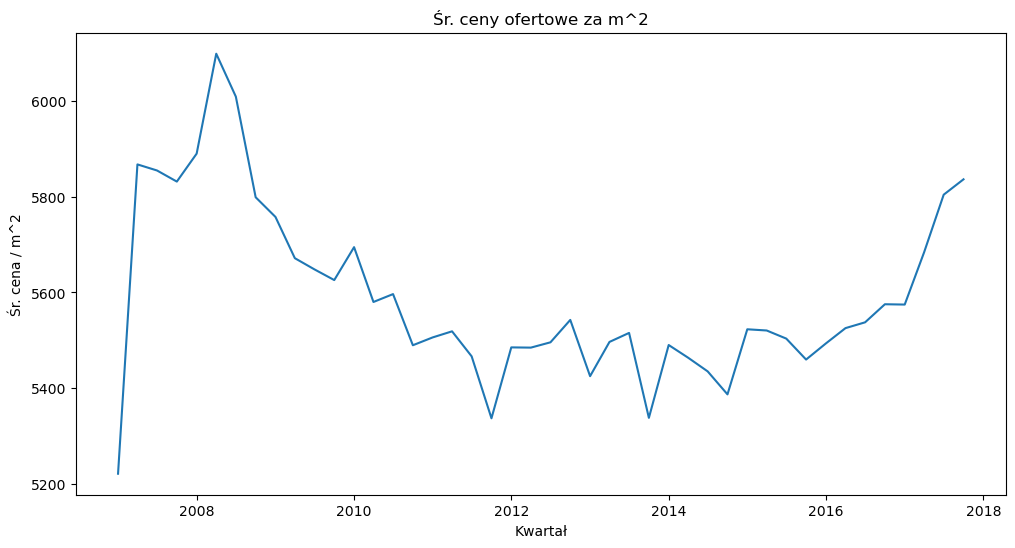

In [13]:
# powtórzenie operacji dla cen ofertowych

df_offer = df[df['Price type'] == 'offer price']
df_offer = df_offer.sort_values(by=['Quarter'])

# wyliczenie średnich cen dla każdego kwartału
df_avg_offer = df_offer.groupby('Quarter')['Price'].mean().reset_index()

# tylko jeden rekord dla 2006-4, więc usuwamy
df_avg_offer = df_avg_offer[~(df_avg_offer['Quarter'].dt.year == 2006)].reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.title('Śr. ceny ofertowe za m^2')
plt.plot(df_avg_offer['Quarter'], df_avg_offer['Price'])
plt.xlabel('Kwartał')
plt.ylabel('Śr. cena / m^2')
plt.show()

In [14]:
result = adfuller(df_avg_offer['Price'], autolag='AIC')
print(f'Statystyka ADF: {result[0]}')
print(f'Wartość p: {result[1]}')

Statystyka ADF: -2.7906431306423873
Wartość p: 0.059622810628872286


In [15]:
for key, value in result[4].items():
    print(f'   {key}: {value}')

   1%: -3.5925042342183704
   5%: -2.931549768951162
   10%: -2.60406594375338


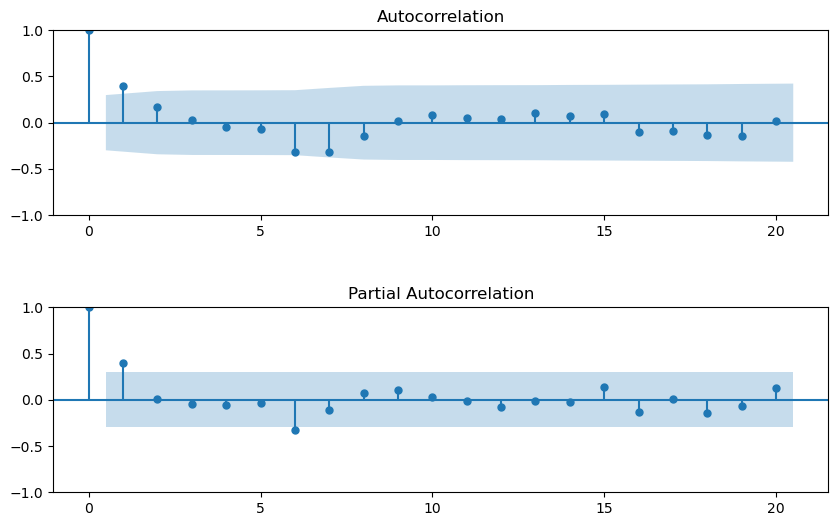

In [16]:
# p < 0.1, ADF < od wartości krytycznej dla 10%, czyli szereg jest stacjonarny (dla poziomu istotności 0.1)
# diff_series = df_avg_offer['Price'].diff().dropna()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
plt.subplots_adjust(hspace=0.5)

plot_acf(diff_series, lags=20, ax=ax[0])
plot_pacf(diff_series, lags=20, ax=ax[1], method='ywm')

plt.show()

In [17]:
df_avg_offer.index = pd.to_datetime(df_avg_offer.index)
df_avg_offer.index = pd.date_range(start=df_avg_offer.index[0], periods=len(df_avg_offer), freq='Q')

df_avg_offer = df_avg_offer.sort_index()

model = ARIMA(df_avg_offer['Price'], order=(1, 0, 1))
results = model.fit()

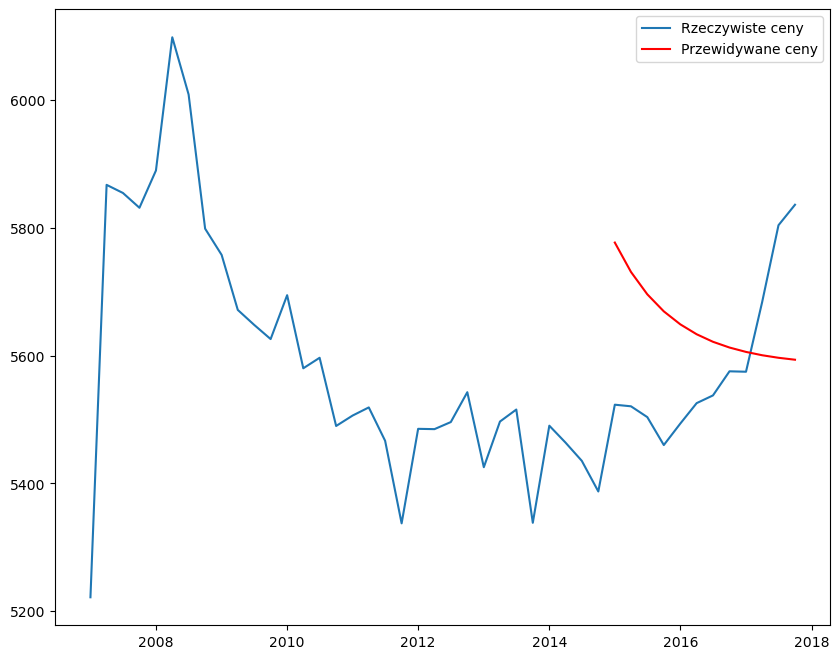

In [18]:
test_set = df_avg_offer['Price'].tail(n=12)

predictions = results.get_forecast(steps=len(test_set))

quarters = df_avg_offer['Quarter']
plt.figure(figsize=(10, 8))
plt.plot(quarters, df_avg_offer['Price'], label='Rzeczywiste ceny')
plt.plot(quarters[-len(test_set):], predictions.predicted_mean, label='Przewidywane ceny', color='red')
plt.legend()
plt.show()

In [19]:
predicted_values = results.fittedvalues

mse = mean_squared_error(df_avg_offer['Price'], predicted_values)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 17069.237724971885


In [20]:
# Czyli model myli się o ok. 131 zł